In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from targets.density_estimation_target import *
import torch
import matplotlib.pyplot as plt

ImportError: cannot import name 'NDR' from 'models' (c:\users\elouan\pycharmprojects\neural-density-ratio\venv\lib\site-packages\models\__init__.py)

In [11]:
import torch
from torch import nn
from tqdm import tqdm

class NDR(nn.Module):
    def __init__(self, target_samples_1, target_samples_2, hidden_dims):
        super().__init__()

        self.target_samples_1 = target_samples_1
        self.target_samples_2 = target_samples_2
        self.p = target_samples_1.shape[-1]

        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1), nn.SiLU(), ])
        network.pop()
        self.logit_r = nn.Sequential(*network)

        self.loss_values=[]

    def loss(self, X,Y):
        log_sigmoid = torch.nn.LogSigmoid()
        return -torch.mean(log_sigmoid(self.logit_r(X))+log_sigmoid(-self.logit_r(Y)))

    def train(self, epochs):
        self.para_list = list(self.parameters())

        self.optimizer = torch.optim.Adam(self.para_list, lr=5e-3)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        X = self.target_samples_1.to(device)
        Y = self.target_samples_2.to(device)

        pbar = tqdm(range(epochs))
        for t in pbar:
            self.optimizer.zero_grad()
            batch_loss = self.loss(X,Y)
            batch_loss.backward()
            self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor(self.loss(X,Y)).item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)))
        self.to(torch.device('cpu'))

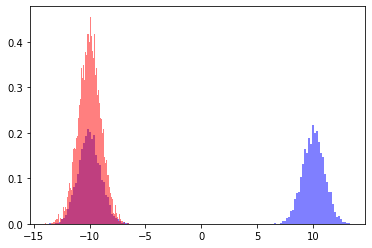

In [25]:
samples_1 = torch.randn(5000).unsqueeze(-1)
samples_1 = samples_1 + 10*torch.ones_like(samples_1)
samples_1_prime = torch.randn(5000).unsqueeze(-1)
samples_1_prime = samples_1_prime - 10*torch.ones_like(samples_1_prime)
samples_1 = torch.cat([samples_1, samples_1_prime], dim = 0)
plt.hist(samples_1.numpy(), color = 'blue',bins =150, density = True, alpha = .5)

samples_2 = torch.randn(10000).unsqueeze(-1)
samples_2 = samples_2 - 10*torch.ones_like(samples_2)
plt.hist(samples_2.numpy(),color = 'red', bins =150, density = True, alpha = .5)
plt.show()

In [26]:
ndr = NDR(samples_1, samples_2, [64,64,64])
ndr.train(1000)

  0%|                                                                                                                                                                                                            | 0/1000 [00:00<?, ?it/s]C:\Users\Elouan\AppData\Local\Temp/ipykernel_12896/2965183039.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iteration_loss = torch.tensor(self.loss(X,Y)).item()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.14it/s, loss = 0.954209]


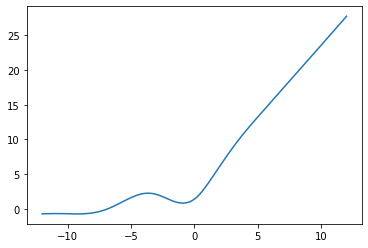

In [29]:
tt = torch.linspace(-12,12,100)
density_ratio = ndr.logit_r(tt.unsqueeze(-1))
plt.plot(tt, density_ratio.detach().numpy())